In [42]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering


stop_words = stopwords.words('spanish')

## Obtención de datos

In [6]:
def fetch_items(cat_id, offset):
    url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
    request = requests.get(url)
    items = request.json()
    return items['results']

def save_items_to_json(cat_id):
    all_items = []
    for offset in range(0, 951, 50):
        items = fetch_items(cat_id, offset)
        all_items.extend(items)
    
    with open('items.json', 'w') as file:
        json.dump(all_items, file)

cat_id = 'MCO1000'
save_items_to_json(cat_id)

with open('items.json', 'r') as file:
    items = json.load(file)

items_results = items.copy()
items_df = pd.json_normalize(items_results)

## Fuciones utilizadas para transformar los datos

In [12]:
def tokenize_title(title):
    tokens = word_tokenize(title)
    return tokens

def remove_stopwords(tokens):
    # Obtiene la lista de stopwords en español
    stop_words = set(stopwords.words('spanish'))
    
    # Filtra los tokens removiendo las stopwords
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    return filtered_tokens


### Extracción y transformación de datos

In [37]:
filtered_items = items_df[['id','title','category_id','price','attributes']].copy()

brand = []
for i in filtered_items['attributes']:
    brand_value = next((attribute['value_name'] for attribute in i if attribute['id'] == 'BRAND'), '')
    brand.append(brand_value)
            
filtered_items['brand']  = brand

filtered_items = filtered_items.dropna(subset=['brand', 'price', 'category_id']).drop('attributes', axis=1)

filtered_items = filtered_items.assign(tokenized_title=filtered_items['title'].apply(tokenize_title)).drop('title', axis=1)

filtered_items['tokenized_title'] = filtered_items['tokenized_title'].apply(remove_stopwords)

filtered_items['tokenized_title'] = [' '.join(tokens) for tokens in filtered_items['tokenized_title']]

filtered_items['category'] = filtered_items['category_id'].apply(lambda x: x[3:] if isinstance(x, str) else x)


### Proceso de analisis 

In [21]:

# Seleccionar columnas de interés
features = filtered_items[['tokenized_title', 'category']]

# Eliminar filas con valores faltantes en las columnas seleccionadas
features = features.dropna()

# Combinar las columnas "descripción" y "categoría" en una sola columna de texto
features['combined_features'] = features['tokenized_title'] + ' ' + features['category']

# Preprocesamiento del texto combinado
vectorizer = TfidfVectorizer()
vectorized_features = vectorizer.fit_transform(features['combined_features'])


### Metodo del codo

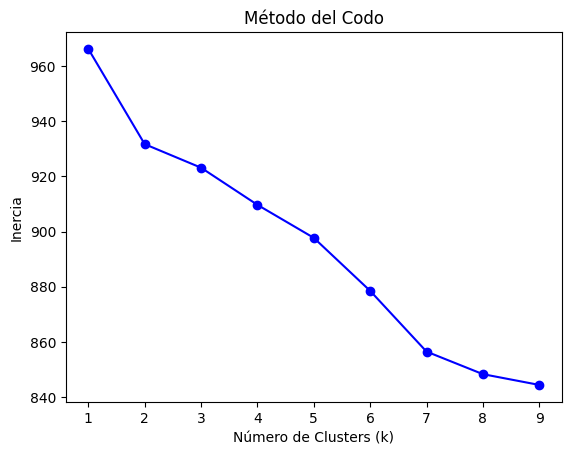

In [47]:

# Calcular la inercia para diferentes valores de k
inertias = []
k_values = range(1, 10)  # Prueba diferentes valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(vectorized_features)
    inertias.append(kmeans.inertia_)

# Graficar la curva de la inercia
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

### Metodo de la silueta

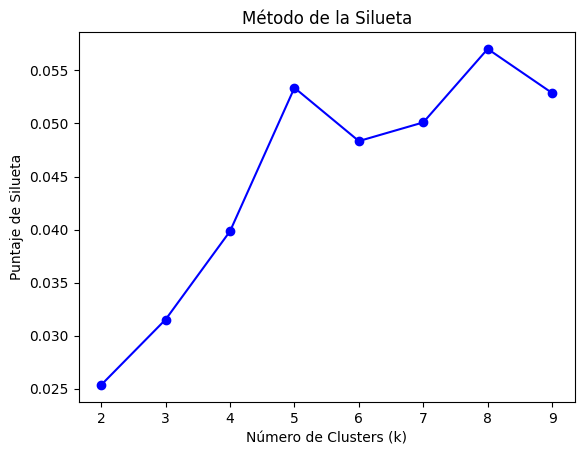

In [48]:
silhouette_scores = []

k_values = range(2, 10)  # Prueba diferentes valores de k
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(vectorized_features)
    labels = kmeans.labels_
    score = silhouette_score(vectorized_features, labels)
    silhouette_scores.append(score)

# Graficar la curva de la silueta promedio
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Puntaje de Silueta')
plt.title('Método de la Silueta')
plt.show()

### Aplicación del modelocon el número de clusters calculado

#### Utilizando Kmeans.fit

In [44]:
# Aplicar el algoritmo de clusterización K-means
k = 6  # Número de clusters deseados
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(vectorized_features)

# Agregar las etiquetas de los clusters al DataFrame original
features['cluster'] = cluster_labels
filtered_items['kmeans_cluster'] = cluster_labels

# Visualizar los resultados
print(features[['combined_features', 'cluster']])




                                     combined_features  cluster
0    Audífonos In-ear Gamer Inalámbricos Xiaomi Red...        5
1    Televisor Samsung 55 Crystal Uhd 4k Bu8200 Sma...        2
2        Audífonos In-ear Inalámbricos F9-5 Negro 3697        5
3    Amazon Echo Dot 3rd Gen Asistente Virtual Alex...        3
4    Smart Tv Samsung Series 5 Un40t5290akxzl Led T...        2
..                                                 ...      ...
995  Audífonos In-ear Inalámbricos Jbl Tune 215tws ...        5
996              Pila Bateria 123 Litio Energizer 7279        4
997  Cable Convertidor Adaptador Hdmi Vga Pc Laptop...        3
998  Televisor Hyundai Q Led 50 Pulgadas Smart 4k 1...        2
999   Televisor Samsung 65 Crystal Uhd 4k Cu7000 14903        2

[995 rows x 2 columns]


#### Utilizando clustering.fit_predict

In [45]:

# Convertir las columnas seleccionadas en una matriz numpy
X = vectorized_features.toarray()

# Crear una instancia del algoritmo AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=6)  

# Ajustar el modelo de clustering a los datos
cluster_labels = clustering.fit_predict(X)
filtered_items['cluster'] = cluster_labels


In [46]:
filtered_items

,id,category_id,price,brand,tokenized_title,category,kmeans_cluster,cluster
0,MCO1341701368,MCO3697,114890,Xiaomi,Audífonos In-ear Gamer Inalámbricos Xiaomi Red...,3697,5,5
1,MCO1137137999,MCO14903,2049980,Samsung,Televisor Samsung 55 Crystal Uhd 4k Bu8200 Sma...,14903,2,1
2,MCO1274347483,MCO3697,28539,Genérica,Audífonos In-ear Inalámbricos F9-5 Negro,3697,5,5
3,MCO1190298977,MCO420273,168403,Amazon,Amazon Echo Dot 3rd Gen Asistente Virtual Alex...,420273,3,3
4,MCO1073842581,MCO14903,1049900,Samsung,Smart Tv Samsung Series 5 Un40t5290akxzl Led T...,14903,2,1
...,...,...,...,...,...,...,...,...
995,MCO1280089373,MCO3697,240000,JBL,Audífonos In-ear Inalámbricos Jbl Tune 215tws ...,3697,5,5
996,MCO625430796,MCO7279,16600,Energizer,Pila Bateria 123 Litio Energizer,7279,4,0
997,MCO612888757,MCO431809,12400,New Print,Cable Convertidor Adaptador Hdmi Vga Pc Laptop...,431809,3,0
998,MCO960356276,MCO14903,1769900,Hyundai,Televisor Hyundai Q Led 50 Pulgadas Smart 4k,14903,2,1
